# **Hierarchical Clustering** April 2025

### Dependencies

In [112]:
import pandas as pd
from pathlib import Path
import numpy as np
import time
import os
import missingno
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from scipy.stats import boxcox
from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN #, HDBSCAN
import umap.umap_ as umap
import matplotlib
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import reduce
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.experimental import enable_iterative_imputer   
from sklearn.impute import IterativeImputer

### Functions and dictonaries

In [135]:
# Clean up column names
clean_column_name_mapping = {
        'expressive_6': 'MSEL 6 months',
    'expressive_12': 'MSEL 12 months',
    'expressive_18': 'MSEL 18 months',
    'expressive_24': 'MSEL 24 months',
    'expressive_36': 'MSEL 36 months',
      'outcome': 'Diagnosis',
    'sex': 'Sex', 
    'site': 'Site',
    'group_type': 'ASD Likelihood',
        'gamma_lat_6': 'Power Lateralization',
    'speech_con_6_left': 'Connectivity Speech',
    'auditory_con_6': 'Connectivity Auditory Network',
    'lang_comp_con_6': 'Connectivity Language',
    'front_gamma_6': 'Frontal Gamma Power', 
    'front_alpha_6': 'Frontal Alpha Power', 
    'stg_lat_6': 'STG Lateralization',
    'lang_lat_6': 'Language Power Lateralization',

}


In [136]:
# Write the data
date= "2025_04_23"
mplus_date = "May_2025"

## Load dasets - including eeg data and behavioural data

In [137]:
neurosubs_df = pd.read_csv("../../Datasets/eeg/clustering/literature/literature_driven_eeg_df_2025_04_15.csv")
clinisubs_df = pd.read_csv("../../Datasets/behaviour/language_datasets/mullen_profiles_sept_2024.csv")  
exploratory_df = pd.read_csv("../../Datasets/eeg/clustering/exploratory/exploratory_driven_language_eeg_df_2025_04_15.csv")


### Merge datasets

In [138]:
# Select only columns that have a 6 or subject_id
eeg_vars_6 = neurosubs_df.columns[neurosubs_df.columns.str.contains("6")]
neurosubs_df = neurosubs_df[neurosubs_df.columns[neurosubs_df.columns.str.contains("6|subject")]]


In [139]:
neurosubs_df=neurosubs_df.merge(clinisubs_df, on="subject", how="left")

In [140]:
neurosubs_df.columns



Index(['subject', 'front_gamma_6', 'auditory_con_6', 'lang_comp_con_6',
       'speech_con_6_left', 'gamma_lat_6', 'receptive_6', 'expressive_6',
       'receptive_12', 'expressive_12', 'receptive_18', 'expressive_18',
       'receptive_24', 'expressive_24', 'receptive_36', 'expressive_36',
       'nonverbal_iq_6', 'nonverbal_iq_12', 'nonverbal_iq_24',
       'nonverbal_iq_36', 'exp_rec_6', 'exp_rec_12', 'exp_rec_24',
       'exp_rec_36', 'site', 'group_type', 'outcome', 'sex',
       'change_expressive', 'change_receptive'],
      dtype='object')

In [141]:
eeg_vars_6

Index(['front_gamma_6', 'auditory_con_6', 'lang_comp_con_6',
       'speech_con_6_left', 'gamma_lat_6'],
      dtype='object')

## Variable exploration

In [142]:
neurosubs_df.dtypes

subject                int64
front_gamma_6        float64
auditory_con_6       float64
lang_comp_con_6      float64
speech_con_6_left    float64
gamma_lat_6          float64
receptive_6          float64
expressive_6         float64
receptive_12         float64
expressive_12        float64
receptive_18         float64
expressive_18        float64
receptive_24         float64
expressive_24        float64
receptive_36         float64
expressive_36        float64
nonverbal_iq_6       float64
nonverbal_iq_12      float64
nonverbal_iq_24      float64
nonverbal_iq_36      float64
exp_rec_6            float64
exp_rec_12           float64
exp_rec_24           float64
exp_rec_36           float64
site                  object
group_type            object
outcome               object
sex                   object
change_expressive    float64
change_receptive     float64
dtype: object

In [143]:
neurosubs_df.describe()

,subject,front_gamma_6,auditory_con_6,lang_comp_con_6,speech_con_6_left,gamma_lat_6,receptive_6,expressive_6,receptive_12,expressive_12,...,nonverbal_iq_6,nonverbal_iq_12,nonverbal_iq_24,nonverbal_iq_36,exp_rec_6,exp_rec_12,exp_rec_24,exp_rec_36,change_expressive,change_receptive
count,144.000000,142.000000,140.000000,142.000000,140.000000,139.000000,144.000000,144.000000,129.000000,129.000000,...,144.000000,128.000000,101.000000,66.000000,144.000000,129.000000,100.000000,66.000000,129.000000,129.000000
mean,379.152778,-21.193356,-1.626427,-1.526289,-1.469691,0.026996,5.930556,6.138889,12.286822,12.387597,...,7.423611,15.378906,25.722772,40.712121,0.208333,0.100775,-1.660000,1.575758,6.248062,6.372093
std,308.659935,0.462951,0.292163,0.142869,0.209401,0.081946,1.740721,1.894457,2.934690,2.762217,...,1.941738,1.960984,3.125280,6.621097,1.808585,2.933761,4.985271,6.035945,2.589133,2.692785
min,2.000000,-22.423862,-2.131852,-1.834335,-1.807833,-0.164802,1.000000,3.000000,5.000000,7.000000,...,4.500000,8.500000,17.500000,21.000000,-4.000000,-8.000000,-14.000000,-9.000000,-1.000000,1.000000
25%,94.000000,-21.462886,-1.830720,-1.636469,-1.632475,-0.023841,5.000000,5.000000,10.000000,10.000000,...,6.000000,14.000000,23.500000,37.625000,-1.000000,-1.000000,-5.000000,-2.000000,5.000000,5.000000
50%,163.500000,-21.178831,-1.742611,-1.534923,-1.503440,0.029445,6.000000,5.500000,13.000000,12.000000,...,7.000000,15.500000,25.500000,41.750000,0.000000,0.000000,-2.000000,2.000000,6.000000,6.000000
75%,666.000000,-20.819562,-1.463354,-1.436651,-1.337794,0.083164,7.000000,7.000000,13.000000,15.000000,...,8.500000,16.500000,28.000000,45.000000,1.000000,2.000000,1.250000,5.000000,8.000000,8.000000
max,937.000000,-20.237827,-0.853801,-1.140094,-0.892425,0.216371,14.000000,14.000000,24.000000,20.000000,...,16.000000,23.000000,32.500000,59.500000,5.000000,8.000000,9.000000,18.000000,12.000000,17.000000


##### Autism Diagnosis 

In [144]:
neurosubs_df["outcome"].value_counts()
# We have a total of 142 (82%) non-asd and 30 (17%) asd cases

no-asd    114
asd        22
Name: outcome, dtype: int64

##### Autism Risk 

In [145]:
neurosubs_df["group_type"].value_counts()
# We have a total of 97 ELA (Elevated likelihood for asd) and 95 TLA (Typical likelihood for asd)

TLA    75
ELA    69
Name: group_type, dtype: int64

#### Site counts

In [146]:
neurosubs_df["site"].value_counts()
# We have a total of 104 in london and 88 in washington

washington    77
london        67
Name: site, dtype: int64

##### Sex differences

In [147]:
neurosubs_df[["sex"]].value_counts()

print( "We have a total of " + str(neurosubs_df[["sex"]].value_counts()[0])  +
 " males " + "and " +  str(neurosubs_df[["sex"]].value_counts()[1]) +
 " females in our dataset")

We have a total of 76 males and 68 females in our dataset


## Analysis of **missingness**

### Missingness before dropping participants

subject               0.000000
front_gamma_6         1.388889
auditory_con_6        2.777778
lang_comp_con_6       1.388889
speech_con_6_left     2.777778
gamma_lat_6           3.472222
receptive_6           0.000000
expressive_6          0.000000
receptive_12         10.416667
expressive_12        10.416667
receptive_18         58.333333
expressive_18        58.333333
receptive_24         30.555556
expressive_24        30.555556
receptive_36         54.166667
expressive_36        54.166667
nonverbal_iq_6        0.000000
nonverbal_iq_12      11.111111
nonverbal_iq_24      29.861111
nonverbal_iq_36      54.166667
exp_rec_6             0.000000
exp_rec_12           10.416667
exp_rec_24           30.555556
exp_rec_36           54.166667
site                  0.000000
group_type            0.000000
outcome               5.555556
sex                   0.000000
change_expressive    10.416667
change_receptive     10.416667
dtype: float64

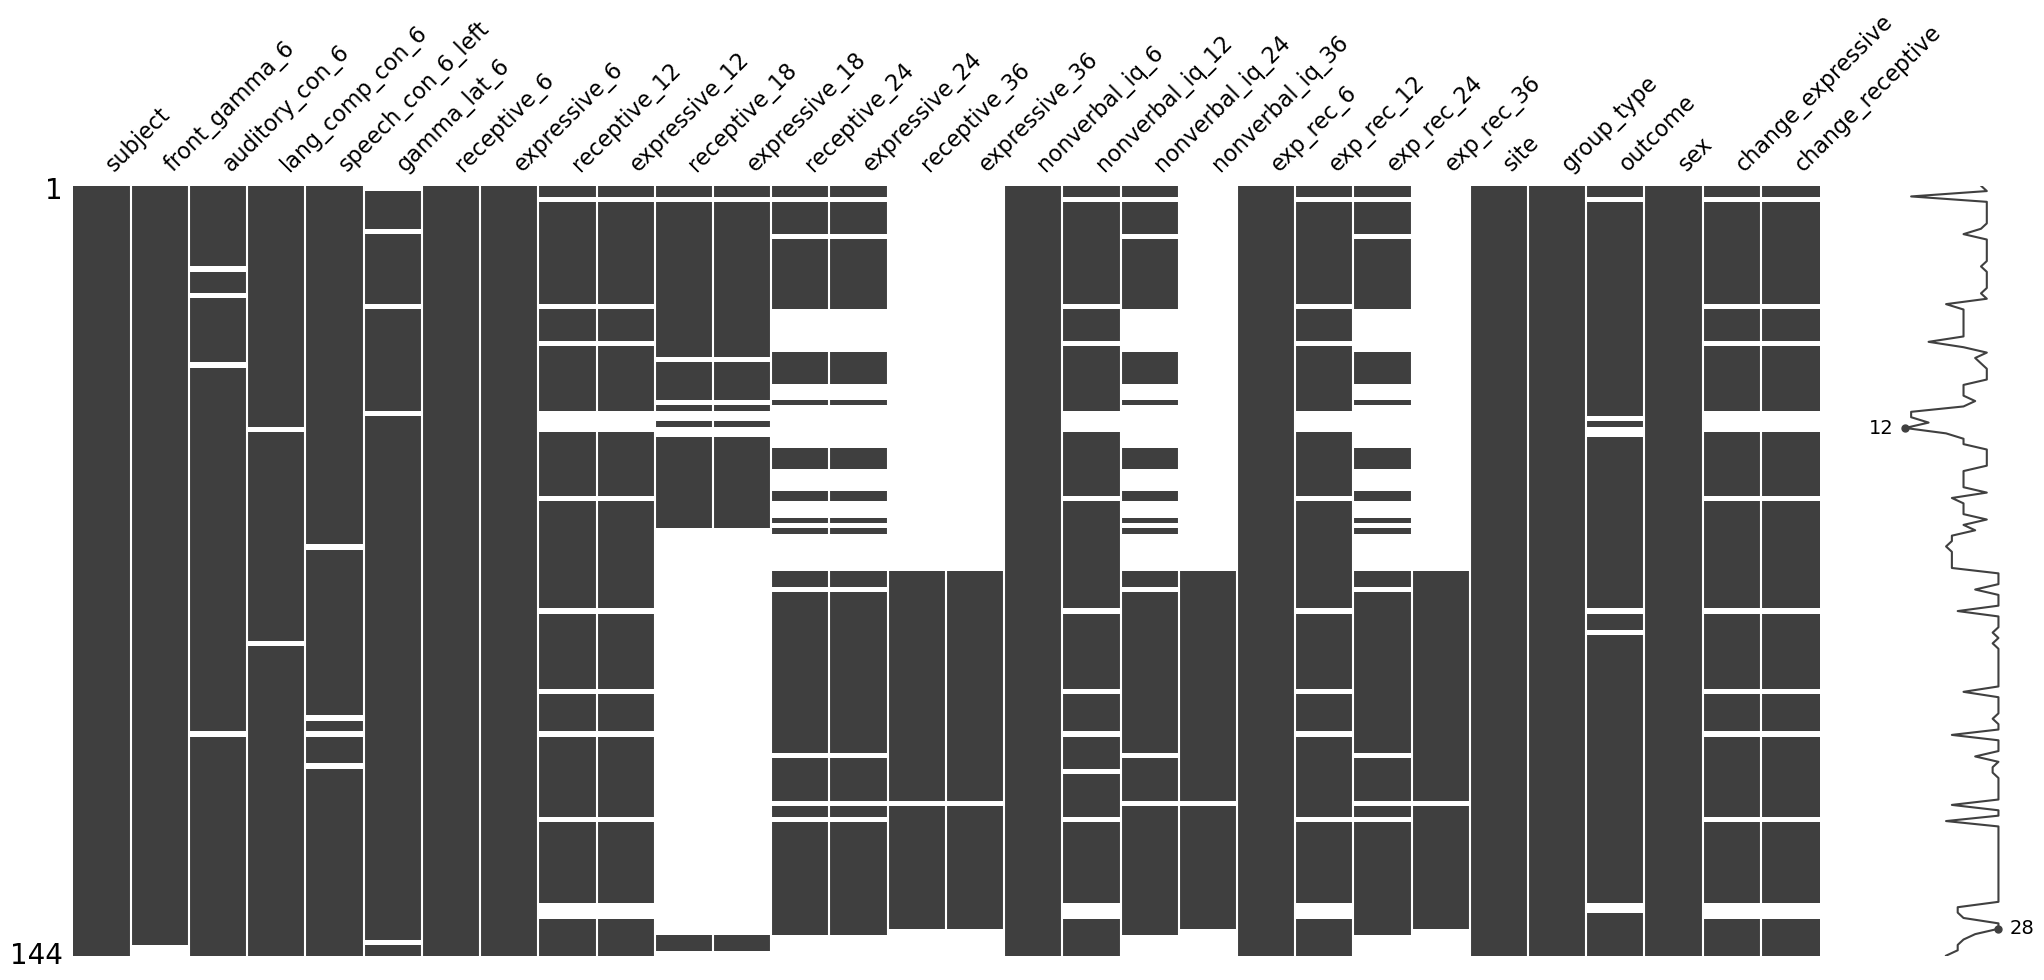

In [148]:
missingno.matrix(neurosubs_df)
neurosubs_df.isna().sum()/len(neurosubs_df)*100
# According to this, maybe we should exclude the variables "change_expressive" and "change_receptive" from the analysis


### Dropping participants without any EEG data

In [149]:
# Check how many subjects had data for at least one of the EEG variables
print("Total number of subjects with data at 6 months: " + str(len(neurosubs_df.dropna(subset=["expressive_6"])))) 
# Check how many subjects had data for at least one of the EEG variables

neurosubs_df = neurosubs_df.dropna(subset=eeg_vars_6, how="all")
# Check how many subjects had data for at least one of the EEG variables
print("Total number of subjects with EEG data: " + str(len(neurosubs_df)))

Total number of subjects with data at 6 months: 144
Total number of subjects with EEG data: 144


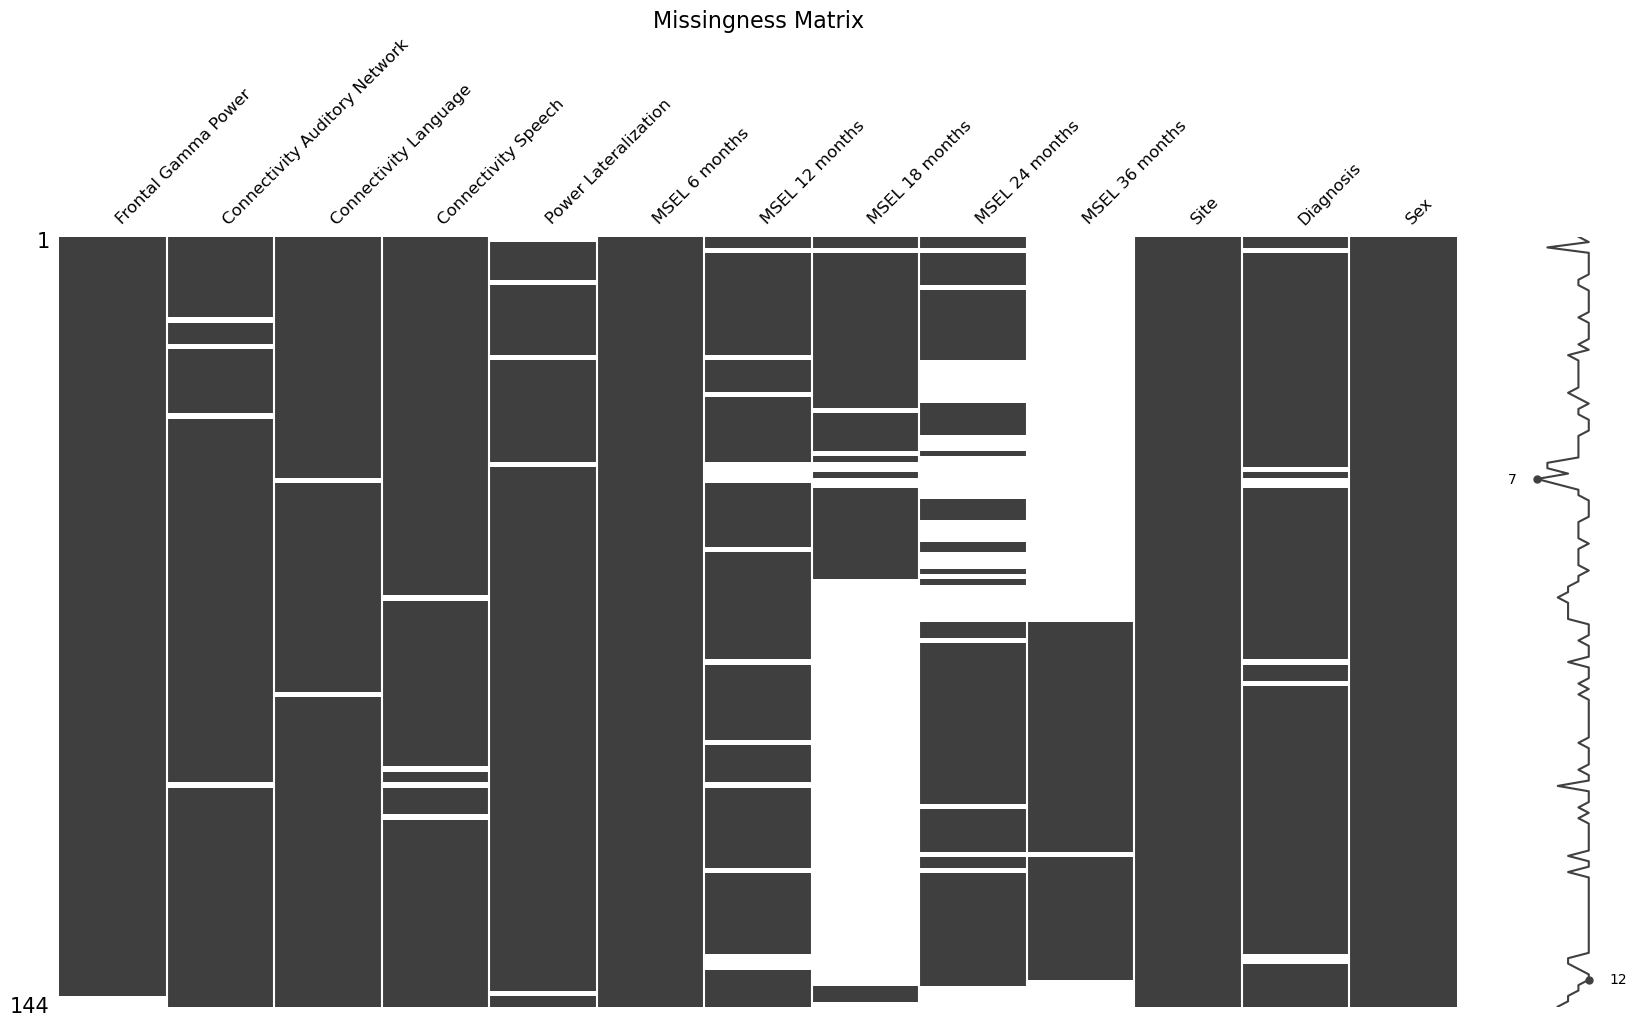

In [150]:
missingness_count = neurosubs_df.isna().sum()  # Count of missing values
missingness_percent = (missingness_count / len(neurosubs_df)) * 100  # Percentage of missing values
missingness_df_graph= neurosubs_df.copy()


# Create missingness df
missingness_df = pd.DataFrame({
    'variable': missingness_count.index,
    'n_missing': missingness_count.values,
    'percent_missing': missingness_percent.values.round(2)
})

# Clean and format the data
missingness_df = missingness_df.sort_values(by='percent_missing', ascending=False)
missingness_df = missingness_df.reset_index(drop=True)
missingness_df['percent_missing'] = missingness_df['percent_missing'].astype(str) + '%'
missingness_df['percent_missing'] = missingness_df['percent_missing'].str.replace('nan%', '0%')

# Apply your column name cleaning
missingness_df['variable'] = missingness_df['variable'].replace(clean_column_name_mapping)

# Filter for specific variables if needed
missingness_df = missingness_df[missingness_df['variable'].str.contains('MSEL|Diagnosis|Site|Sex|Connectivity|Power')]

# Sort based on your clean_column_name_mapping dictionary
missingness_df['variable'] = pd.Categorical(
    missingness_df['variable'], 
    categories=list(clean_column_name_mapping.values()), 
    ordered=True
)
missingness_df = missingness_df.sort_values('variable')

# Save the missingness table to a csv file and create output directory if it doesn't exist
output_dir = Path(f"../../Tables/Supplementary/{date}/")
output_dir.mkdir(parents=True, exist_ok=True)

missingness_df.to_csv(output_dir / f"missingness_table_after_exclusions_{date}.csv", index=False)

# Create missignness plot/matrix
missingness_df_graph = missingness_df_graph.rename(columns=clean_column_name_mapping)

# Select only the columns that are in the missingness_df
missingness_df_graph = missingness_df_graph[missingness_df_graph.columns[missingness_df_graph.columns.isin(missingness_df['variable'])]]

# Plot the missingness matrix
missingno.matrix(missingness_df_graph, figsize=(20, 10), fontsize=12)
plt.title("Missingness Matrix", fontsize=16)
output_dir = Path(f"../../Figures/Supplementary/{date}/")
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / f"missingness_matrix_after_exclusions_{date}.png", dpi=300, bbox_inches='tight')



## **Demographics** after dropping participants with no EEG data 

##### Autism Diagnosis 

In [151]:
neurosubs_df["outcome"].value_counts()
# We have a total of 114 (82%) non-asd and 22 (17%) asd cases

no-asd    114
asd        22
Name: outcome, dtype: int64

##### Autism Risk 

In [152]:
neurosubs_df["group_type"].value_counts()
# We have a total of 69 ELA (Elevated likelihood for asd) and 75 TLA (Typical likelihood for asd)

TLA    75
ELA    69
Name: group_type, dtype: int64

#### Site counts

In [153]:
neurosubs_df["site"].value_counts()
# We have a total of 77 in london and 67 in washington

washington    77
london        67
Name: site, dtype: int64

##### Sex differences

In [154]:
neurosubs_df[["sex"]].value_counts()

print( "We have a total of " + str(neurosubs_df[["sex"]].value_counts()[0])  +
 " males " + "and " +  str(neurosubs_df[["sex"]].value_counts()[1]) +
 " females in our dataset")

We have a total of 76 males and 68 females in our dataset


In [155]:
neurosubs_df

,subject,front_gamma_6,auditory_con_6,lang_comp_con_6,speech_con_6_left,gamma_lat_6,receptive_6,expressive_6,receptive_12,expressive_12,...,exp_rec_6,exp_rec_12,exp_rec_24,exp_rec_36,site,group_type,outcome,sex,change_expressive,change_receptive
0,2,-21.420116,-1.598480,-1.161137,-1.225266,NaN,5.0,5.0,13.0,13.0,...,0.0,0.0,-7.0,NaN,washington,ELA,no-asd,M,8.0,8.0
1,3,-21.072590,-1.829292,-1.516043,-1.659758,0.040530,8.0,7.0,14.0,14.0,...,-1.0,0.0,-6.0,NaN,washington,ELA,no-asd,M,7.0,6.0
2,5,-22.141673,-1.823852,-1.619339,-1.464546,-0.016544,6.0,5.0,NaN,NaN,...,-1.0,NaN,NaN,NaN,washington,TLA,NaN,M,NaN,NaN
3,6,-21.630370,-1.429544,-1.602488,-1.757113,-0.164802,6.0,4.0,13.0,12.0,...,-2.0,-1.0,-1.0,NaN,washington,ELA,no-asd,M,8.0,7.0
4,8,-21.588120,-1.765373,-1.587519,-1.432471,-0.108383,6.0,5.0,11.0,8.0,...,-1.0,-3.0,-4.0,NaN,washington,ELA,asd,M,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,915,-20.919022,-1.788839,-1.603515,-1.522898,0.042839,5.0,5.0,13.0,15.0,...,0.0,2.0,-4.0,NaN,washington,TLA,no-asd,M,10.0,8.0
140,933,-21.463387,-1.071994,-1.285763,-1.526620,-0.097921,8.0,5.0,13.0,10.0,...,-3.0,-3.0,NaN,NaN,washington,TLA,asd,M,5.0,5.0
141,937,-21.106285,-1.762447,-1.702147,-1.740539,NaN,7.0,6.0,8.0,10.0,...,-1.0,2.0,NaN,NaN,washington,TLA,no-asd,M,4.0,1.0
142,51,NaN,-1.490023,-1.357769,-1.000501,-0.088992,6.0,5.0,11.0,12.0,...,-1.0,1.0,NaN,NaN,washington,TLA,no-asd,M,7.0,5.0


## **Correlations** between EEG variables

C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\195402872.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corr_df.corr().abs().round(2)
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\195402872.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


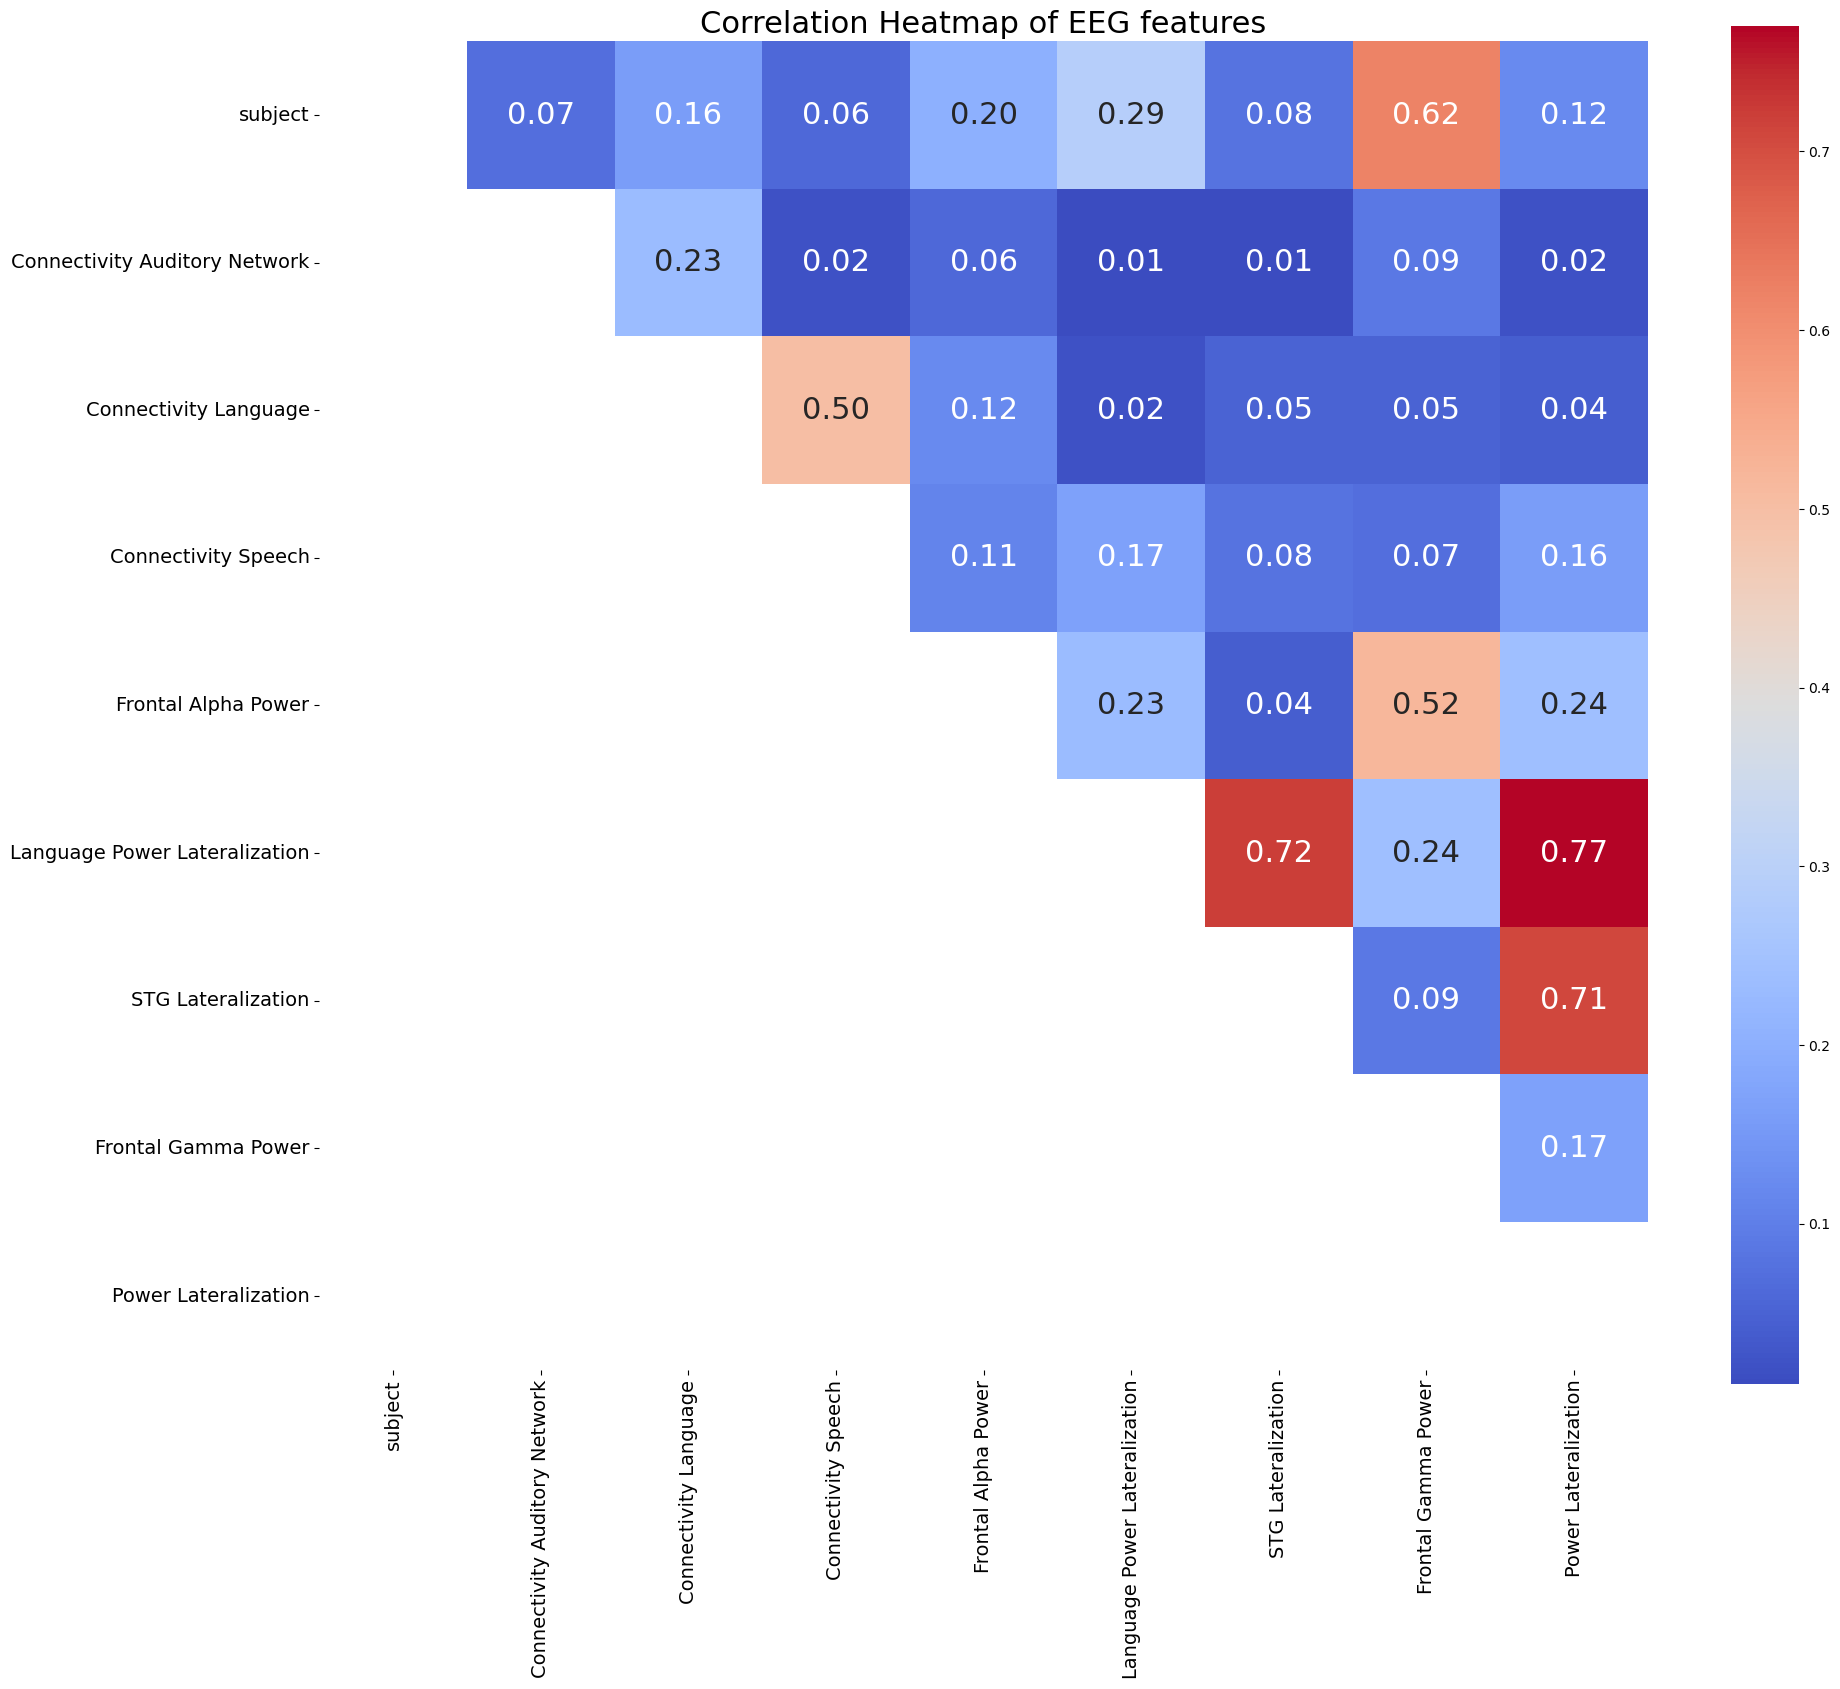

In [156]:
# Identify highly correlated variables for 20D

corr_df = exploratory_df.copy()

corr_df.rename(columns=clean_column_name_mapping, inplace=True)

# Calculate the correlation matrix
corr_matrix = corr_df.corr().abs().round(2)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    upper,  # Your correlation matrix (upper triangle)
    cmap="coolwarm",
    annot=True,  # Show values
    annot_kws={"size": 22},  # Adjust font size here
    fmt=".2f",  # Format to 2 decimal places
    square=True,  # Keep cells square
    cbar_kws={"shrink": 0.75}  # Adjust color bar size
)
plt.title("Correlation Heatmap of EEG features", fontsize=22)
# increase the font size of the numbers in the heatmap
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()


# Save the heatmap to a file
output_dir = Path(f"../../Figures/Supplementary/{date}/")
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / f"correlation_heatmap_{date}.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the correlation matrix to a CSV file
output_dir = Path(f"../../Tables/Supplementary/{date}/")
output_dir.mkdir(parents=True, exist_ok=True)
corr_matrix.to_csv(output_dir / f"correlation_matrix_{date}.csv")



In [158]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

print(f"Columns to drop: {to_drop}")
to_drop

print ("Originally, we had " + str(len(eeg_vars_6)) + " features. After removing the highly correlated features, we have " + str(len(to_drop)) + " features to drop.")

Columns to drop: ['STG Lateralization', 'Power Lateralization']
Originally, we had 5 features. After removing the highly correlated features, we have 2 features to drop.


In [159]:
eeg_vars_6

Index(['front_gamma_6', 'auditory_con_6', 'lang_comp_con_6',
       'speech_con_6_left', 'gamma_lat_6'],
      dtype='object')

## **Hierarchical clustering** 

#### Select which features to run

In [163]:
# Create dictionary with the variables to be used in the analysis

eeg_analysis_variables = {  "2D": ["gamma_lat_6", "speech_con_6_left"],
                       #   "3D_power_gamma_con": ["front_gamma_6", "gamma_lat_6", "speech_con_6_left"],
                            "3D_con": ["speech_con_6_left", "auditory_con_6","lang_comp_con_6"],
                            "5D": eeg_vars_6.tolist()}


*** 2D ***
2D
Shape before dropping participants  (144, 30)
ASD value counts before: ASD= 22 Non-ASD= 114
Risk value counts before: TLA= 69 ELA= 75
Both dataframes have the same number of rows
MICE  Shape after dropping participants: (144, 28)
ASD value counts after: ASD= 22 Non-ASD= 114
Risk value counts after: TLA= 69 ELA= 75


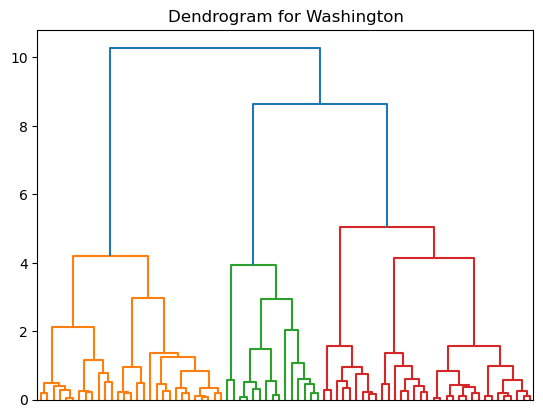

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

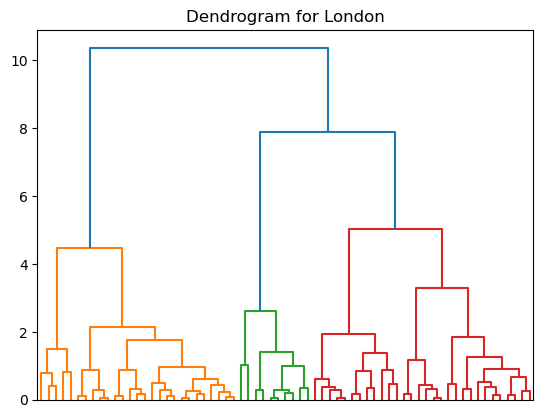

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

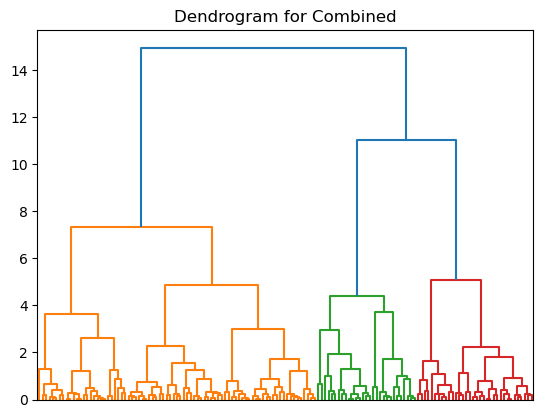

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 

*** 3D_con ***
3D_con
Shape before dropping participants  (144, 30)
ASD value counts before: ASD= 22 Non-ASD= 114
Risk value counts before: TLA= 69 ELA= 75
Both dataframes have the same number of rows
MICE  Shape after dropping participants: (144, 29)
ASD value counts after: ASD= 22 Non-ASD= 114
Risk value counts after: TLA= 69 ELA= 75


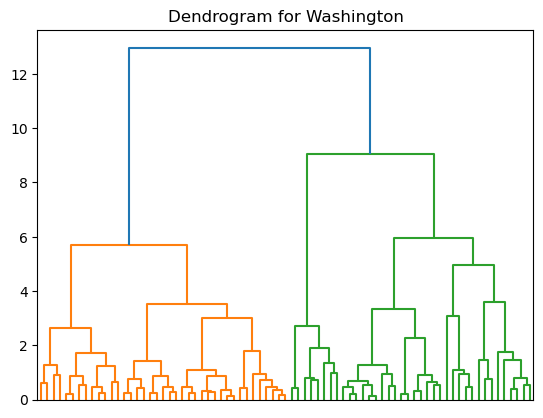

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

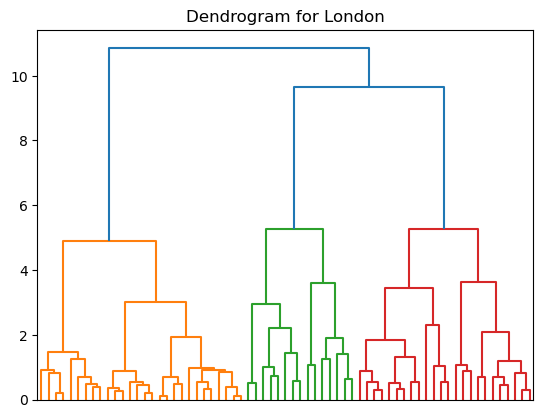

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

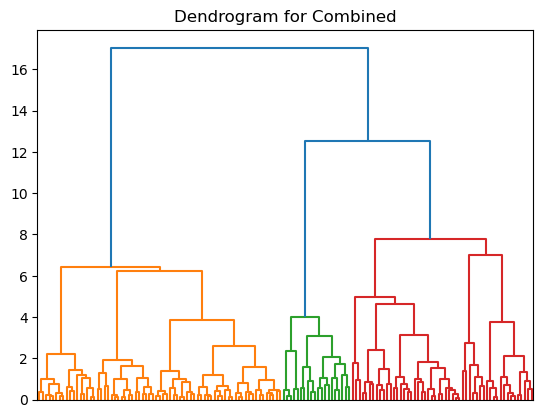

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 

*** 5D ***
5D
Shape before dropping participants  (144, 30)
ASD value counts before: ASD= 22 Non-ASD= 114
Risk value counts before: TLA= 69 ELA= 75
Both dataframes have the same number of rows
MICE  Shape after dropping participants: (144, 31)
ASD value counts after: ASD= 22 Non-ASD= 114
Risk value counts after: TLA= 69 ELA= 75


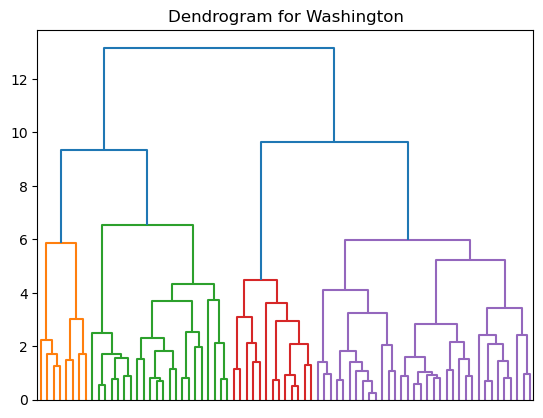

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

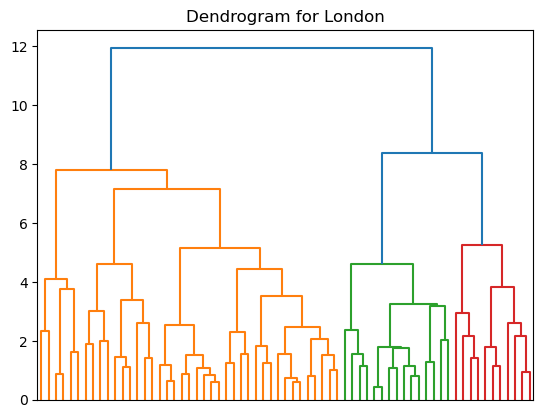

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

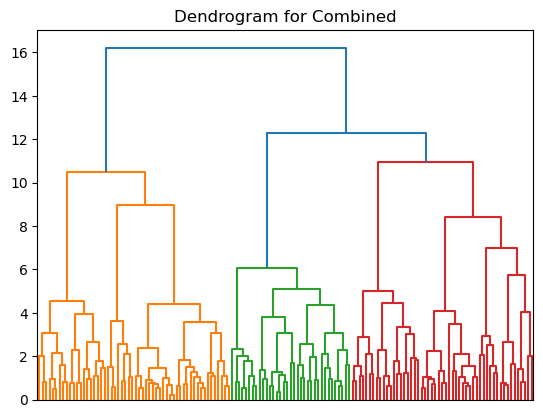

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 

*** 2D ***
2D
Shape before dropping participants  (144, 30)
ASD value counts before: ASD= 22 Non-ASD= 114
Risk value counts before: TLA= 69 ELA= 75
listwise_deletion  Shape after dropping participants: (135, 30)
ASD value counts after: ASD= 21 Non-ASD= 106
Risk value counts after: TLA= 64 ELA= 71


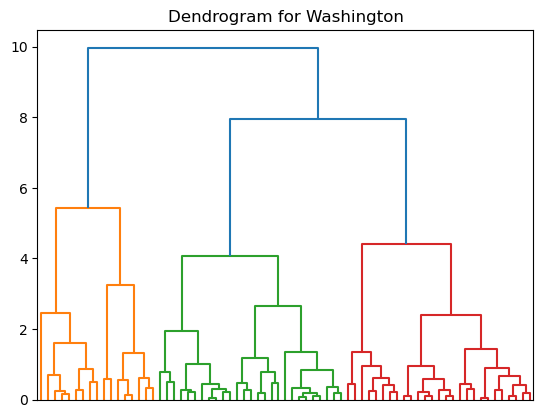

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

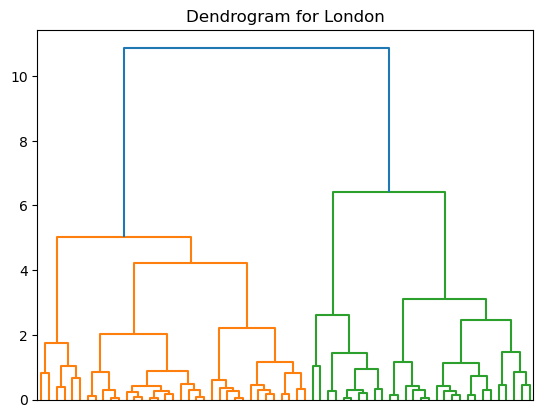

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

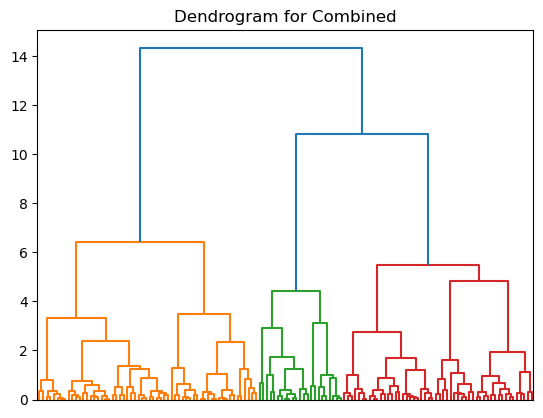

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 

*** 3D_con ***
3D_con
Shape before dropping participants  (144, 30)
ASD value counts before: ASD= 22 Non-ASD= 114
Risk value counts before: TLA= 69 ELA= 75
listwise_deletion  Shape after dropping participants: (135, 30)
ASD value counts after: ASD= 20 Non-ASD= 108
Risk value counts after: TLA= 64 ELA= 71


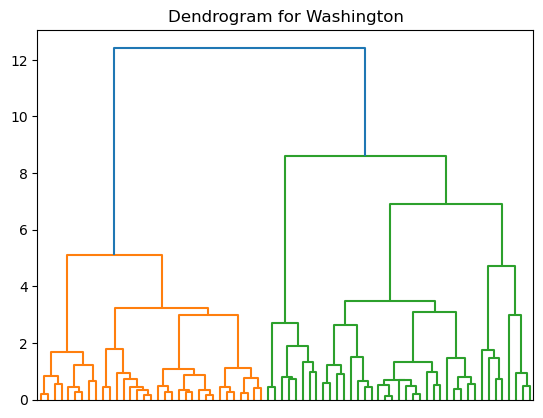

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

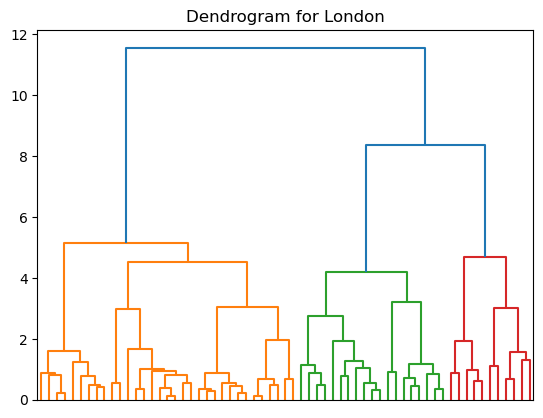

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

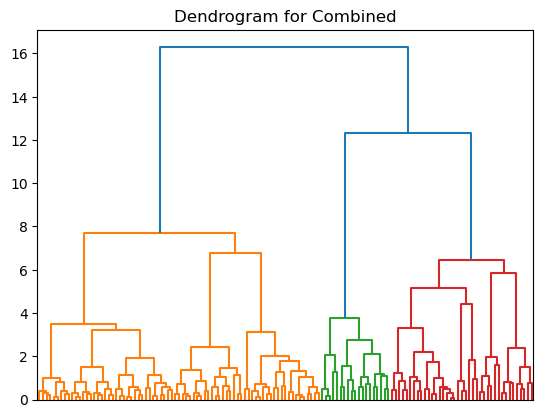

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 

*** 5D ***
5D
Shape before dropping participants  (144, 30)
ASD value counts before: ASD= 22 Non-ASD= 114
Risk value counts before: TLA= 69 ELA= 75
listwise_deletion  Shape after dropping participants: (128, 30)
ASD value counts after: ASD= 20 Non-ASD= 101
Risk value counts after: TLA= 61 ELA= 67


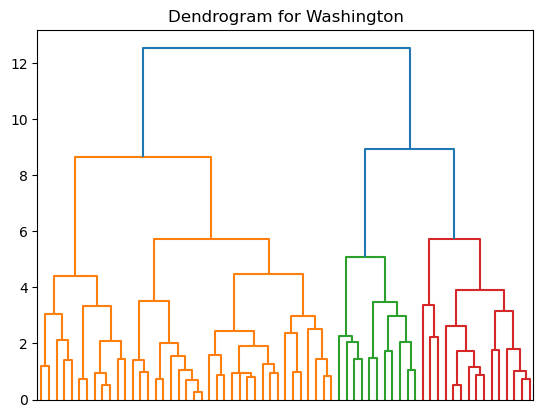

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

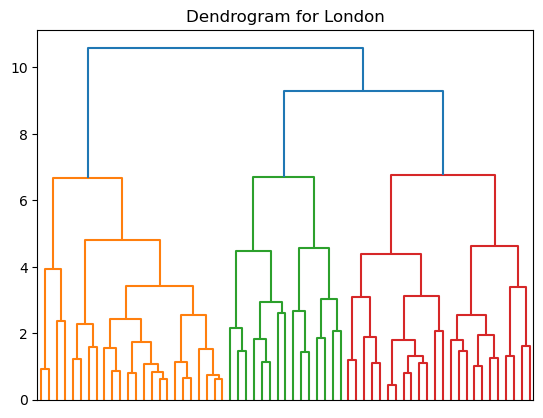

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df[cluster_name] = hc_labels
C:\Users\gabot\AppData\Local\Temp\ipykernel_3412\3678006337.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_df["cluster"] = hc_labels
c:\Us

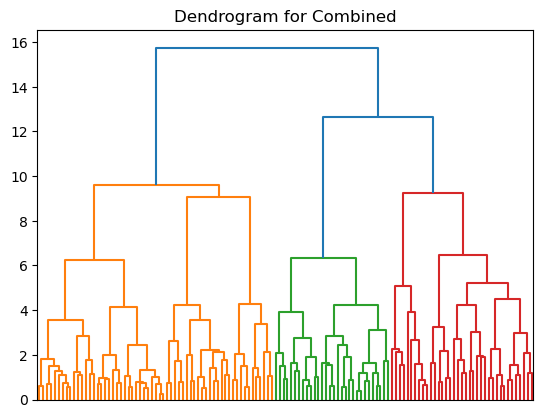

c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\gabot\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 

In [164]:
# Create script for each of the analyses

analysis_type=["MICE", "listwise_deletion"]

for analysis_type in analysis_type:
    for condition, eeg_vars in eeg_analysis_variables.items():
        print("***", condition ,"***")  

        # Select variables of interest 
        behav_vars=['subject','group_type','outcome', 'sex', "site"]
        variables_of_interest = behav_vars + eeg_vars
        variables_of_interest


        # Create a new dataframe with the variables to be used in the analysis
        complete_eeg_df = neurosubs_df.copy()

        # Drop all rows where there is missing EEG data
        print (condition)
        print("Shape before dropping participants ", complete_eeg_df.shape)
        print("ASD value counts before: ASD=", complete_eeg_df["outcome"].value_counts()[1], "Non-ASD=", complete_eeg_df["outcome"].value_counts()[0])
        print("Risk value counts before: TLA=", complete_eeg_df["group_type"].value_counts()[1], "ELA=", complete_eeg_df["group_type"].value_counts()[0])

        # Save ouputs to Mplus
        if not os.path.exists(f"../../Datasets/mplus/{mplus_date}/{condition}"):
            os.makedirs(f"../../Datasets/mplus/{mplus_date}/{condition}")

        full_dataset= complete_eeg_df[variables_of_interest].copy()
        full_dataset.to_csv(f"../../Datasets/mplus/{mplus_date}/{condition}/full_{date}_{condition}.csv", index=False)

        # Save EEG only dataset as .dat file and drop headers to comply with Mplus requirements
        eeg_only_df= complete_eeg_df[eeg_vars].copy()

        # Fill missing values with "999"
        eeg_only_df.fillna(999, inplace=True)
        eeg_only_df.to_csv(f"../../Datasets/mplus/{mplus_date}/{condition}/mplus_{date}_{condition}.dat", index=False, header=False)

        # Remove outliers
        #for var in eeg_vars:
            #complete_eeg_df = remove_outliers_q1k(complete_eeg_df, var, transform=False)


        if analysis_type == "listwise_deletion":

            complete_eeg_df.dropna(subset=eeg_vars, how="any", inplace=True)

        if analysis_type == "MICE":
            ## MICE IMPUTATION
            mice_imputed_df = complete_eeg_df[eeg_vars].copy()
            ## convert categorical columns to int 
        # mice_imputed_df['site'] = mice_imputed_df['site'].astype('category').cat.codes
        # mice_imputed_df['group_type'] = mice_imputed_df['group_type'].astype('category').cat.codes
        # mice_imputed_df['outcome'] = mice_imputed_df['outcome'].astype('category').cat.codes
        # mice_imputed_df['sex'] = mice_imputed_df['sex'].astype('category').cat.codes

            mice_imputer = IterativeImputer(max_iter=40, random_state=0)
            mice_imputed_df = mice_imputer.fit_transform(mice_imputed_df)

            mice_imputed_df = pd.DataFrame(mice_imputed_df, columns=eeg_vars)

            mice_imputed_df["total_missing_values"] = mice_imputed_df.isna().sum(axis=1)
            mice_imputed_df["total_missing_values"].value_counts().sort_index()


            #[['front_gamma_6', 'front_gamma_12', 'gamma_lat_6', 'gamma_lat_12',
            # 'short_con_6', 'short_con_12', 'change_front_gamma', 'change_gamma_lat',
                #'change_short_con', 'subject',]]

            # Make sure both mice_imputed_df and clinisubs_df have the same number of rows
            if len(mice_imputed_df) == len(complete_eeg_df):
                print("Both dataframes have the same number of rows")
                # Merge the two dataframes
                mice_imputed_df.reset_index(drop=True, inplace=True)
                sub_ids=complete_eeg_df.copy()
                sub_ids.reset_index(drop=True, inplace=True)
                mice_imputed_df["subject"] = sub_ids["subject"]
            else:
                print ("************************* MICE FAILED *************************")

            complete_eeg_df = mice_imputed_df.merge(clinisubs_df, on="subject", how="left")

        print(analysis_type, " Shape after dropping participants:", complete_eeg_df.shape)
        print("ASD value counts after: ASD=", complete_eeg_df["outcome"].value_counts()[1], "Non-ASD=", complete_eeg_df["outcome"].value_counts()[0])
        print("Risk value counts after: TLA=", complete_eeg_df["group_type"].value_counts()[1], "ELA=", complete_eeg_df["group_type"].value_counts()[0])

        neurosubs_df2= complete_eeg_df[variables_of_interest].copy()

        # Do analysis for each site and save the data
        sites = ["london", "washington", "combined"]    


        for site in sites:
            if site == "london":
                london_df =complete_eeg_df.loc[complete_eeg_df.site == "london"] # Selecting only the london data

            #  for var in eeg_vars: # Handle outliers
                #    london_df = remove_outliers_q1k(london_df, var, transform=False)
                london_df_eeg= london_df[eeg_vars]  # Selecting only X number of features

                london_df_normed = (london_df_eeg.copy() - np.mean(london_df_eeg, axis=0)) / np.std(london_df_eeg, axis=0) # Normalizing the data
                if not os.path.exists(f"../../Datasets/hierarchical/source/{date}/london"):
                    os.makedirs(f"../../Datasets/hierarchical/source/{date}/london")
                london_df_normed.to_csv(f"../../Datasets/hierarchical/source/{date}/london/london_data_{date}.csv", index=False)   # Saving the data
            # Repeat the same process for the washington data 
            elif site == "washington":
                washington_df =complete_eeg_df.loc[complete_eeg_df.site == "washington"]
            #  for var in eeg_vars: # Handle outliers
                # washington_df = remove_outliers_q1k(washington_df, var, transform=False)        
                washington_df_eeg= washington_df[eeg_vars]
                washington_df_normed = (washington_df_eeg.copy() - np.mean(washington_df_eeg, axis=0)) / np.std(washington_df_eeg, axis=0)
                # Create ditrectory if it does not exist
                if not os.path.exists(f"../../Datasets/hierarchical/source/{date}/washington"):
                    os.makedirs(f"../../Datasets/hierarchical/source/{date}/washington")
                washington_df_normed.to_csv(f"../../Datasets/hierarchical/source/{date}/washington/washington_data_{date}.csv", index=False)
            # Repeat the same process for the combined data
            else:
                combined_df = complete_eeg_df
            # for var in eeg_vars:
                #  combined_df = remove_outliers_q1k(combined_df, var, transform=False)
                combined_df_eeg= combined_df[eeg_vars]
                combined_df_normed = (combined_df_eeg.copy() - np.mean(combined_df_eeg, axis=0)) / np.std(combined_df_eeg, axis=0)
                if analysis_type == "MICE":
                    if not os.path.exists(f"../../Datasets/hierarchical/source/{date}/combined/MICE"):
                        os.makedirs(f"../../Datasets/hierarchical/source/{date}/combined/MICE")
                    combined_df_normed.to_csv(f"../../Datasets/hierarchical/source/{date}/combined/MICE/{condition}combined_data_{date}.csv", index=False)
                elif analysis_type == "listwise_deletion":
                    if not os.path.exists(f"../../Datasets/hierarchical/source/{date}/combined/listwise_deletion"):
                        os.makedirs(f"../../Datasets/hierarchical/source/{date}/combined/listwise_deletion")
                    combined_df_normed.to_csv(f"../../Datasets/hierarchical/source/{date}/combined/listwise_deletion/{condition}_combined_data.csv", index=False)

        clusters_df=combined_df.copy() # Create a copy of the dataframe for later graphing purposes
        clusters_df= london_df.copy() # Selecting only the london data
        clusters_df= washington_df.copy() # Selecting only the washington data

    ## Clusering analysis
        list_of_clusters = []

        #clusters_df = regression_df.copy()

        clusters_df = complete_eeg_df.copy()
        # Dictionary containing the dataframes of each site
        data_sites = {
            "washington": (washington_df_normed, washington_df),
            "london": (london_df_normed, london_df),
            "combined": (combined_df_normed, combined_df)
        }

        for site_name, (site_df_normed, site_df) in data_sites.items():
            # Perform dendrogram plotting
            model_selected = site_df_normed.values
            linkage_data = linkage(model_selected, method='ward', metric='euclidean')
            dendrogram(linkage_data, labels=site_df["subject"].values, leaf_rotation=90, leaf_font_size=10)
            plt.title(f'Dendrogram for {site_name.capitalize()}')
            # Get rid of the x-axis
            plt.xticks([])
            if condition == "5D":
                plt.savefig(f"../../Figures/Supplementary/{date}/dendrogram_{site_name}_{date}.png", dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

            # Perform hierarchical clustering
            for cluster_n in range(2, 11):
                hierarchical_cluster = AgglomerativeClustering(n_clusters=cluster_n, affinity='euclidean', linkage='ward')
                hc_labels = hierarchical_cluster.fit_predict(model_selected)

                # Add the cluster labels to the dataframe
                cluster_name = f"cluster{cluster_n}d{site_name[:3]}"
                site_df[cluster_name] = hc_labels
                site_df["cluster"] = hc_labels

                # Obtain IDs
                cluster_ids = site_df[["subject", cluster_name]].copy()

                # Merge with the main dataframe
                clusters_df = clusters_df.merge(cluster_ids, on="subject", how="left")

                list_of_clusters.append(cluster_name)

        # Save the dataframes

        # Make dir if it does not exist
        if not os.path.exists(f"../../Datasets/hierarchical/clustering_solutions/{date}/MICE"):
            os.makedirs(f"../../Datasets/hierarchical/clustering_solutions/{date}/MICE")
        if not os.path.exists(f"../../Datasets/hierarchical/clustering_solutions/{date}/listwise_deletion"):
            os.makedirs(f"../../Datasets/hierarchical/clustering_solutions/{date}/listwise_deletion")
        # Save cluster solutions 
        if analysis_type == "MICE":
            clusters_df.to_csv(f"../../Datasets/hierarchical/clustering_solutions/{date}/MICE/{condition}_cluster_solutions_6m_{date}.csv", index=False)
        else:
            clusters_df.to_csv(f"../../Datasets/hierarchical/clustering_solutions/{date}/listwise_deletion/{condition}_cluster_solutions_6mo_{date}.csv", index=False)


